In [1]:
import pandas as pd
import numpy as np
np.__version__
import matplotlib.pyplot as plt
_FOLDER = "../data/"
_FOLDER2 = "../results/"
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import \
    KFold, RepeatedKFold, GridSearchCV, \
    cross_validate, train_test_split
import json

In [2]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [3]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCLAndParams.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(trainTestSplit.keys())

88

In [5]:
# filterPlateau = filterPlateau[~filterPlateau['DRUG_ID'].isin(toDropDrugs)]
params = ['param_1', 'param_2','param_3','param_4']
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC']+params
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels
ridgeResults = pd.DataFrame(columns=fullPredLabels)
lassoResults = pd.DataFrame(columns=fullPredLabels)
combinedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ resp_labels + params)
df = None
for drugId in trainTestSplit.keys():
    drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
    trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
    testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
    testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
    notXValuesFilter = resp_labels + notIncludeColumns + conc_labels
    trainXValues = trainData.drop(columns = notXValuesFilter)
    trainYValues = trainData[resp_labels]

    trainX = trainXValues.reset_index(drop=True).to_numpy()
    trainY = trainYValues.reset_index(drop=True).to_numpy()

    testXValues = testData.drop(columns = notXValuesFilter)
    testYValues = testData[resp_labels]
    testParamsValues = testData[params]

    testX = testXValues.reset_index(drop=True).to_numpy()
    testY = testYValues.reset_index(drop=True).to_numpy()
    testParams = testParamsValues.reset_index(drop=True).to_numpy()

    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    ridge_alphas = np.linspace(0, 600, 40)
    ridge = Ridge()
    grid = dict()
    grid['alpha'] = ridge_alphas
    gscv = GridSearchCV( \
        ridge, grid, scoring='neg_mean_absolute_error', \
        cv=cv, n_jobs=-1)
    results = gscv.fit(trainX, trainY)
    print(results.best_params_)

    ridge = Ridge(alpha=results.best_params_['alpha'])
    ridge.fit(trainX, trainY)
    pred_train = ridge.predict(trainX)
    pred_test= ridge.predict(testX)
    resultsRidge = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    resultsRidge[pred_resp_labels] = pred_test
    ridgeResults = ridgeResults.append(resultsRidge,ignore_index=True,sort=False)

    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    lasso_alphas = np.linspace(0, 5, 10)
    lasso = Lasso()
    grid = dict()
    grid['alpha'] = lasso_alphas
    gscv = GridSearchCV( \
        lasso, grid, scoring='neg_mean_absolute_error', \
        cv=cv, n_jobs=-1)
    results = gscv.fit(trainX, trainY)
    print(results.best_params_)

    lasso = Lasso(alpha=results.best_params_['alpha'])
    lasso.fit(trainX, trainY)
    pred_trainL = lasso.predict(trainX)
    pred_testL= lasso.predict(testX)
    resultsLasso = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    resultsLasso[pred_resp_labels] = pred_testL
    lassoResults = lassoResults.append(resultsLasso,ignore_index=True,sort=False)

    trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    trueResult[resp_labels] = testY
    trueResult[params] = testParams
    trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)


    combinedResult = np.add(pred_test, pred_testL)
    divide2 = lambda i: float(i) / 2

    vectorized_divide2 = np.vectorize(divide2)

    combinedResult = np.asmatrix(vectorized_divide2(combinedResult))
    resultsComb = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
    resultsComb[pred_resp_labels] = combinedResult
    combinedResults = combinedResults.append(resultsComb,ignore_index=True,sort=False)



{'alpha': 123.07692307692308}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 123.07692307692308}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 76.92307692307692}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 61.53846153846154}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 169.23076923076923}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 323.0769230769231}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 107.6923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 400.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 15.384615384615385}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 323.0769230769231}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 76.92307692307692}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 30.76923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 415.3846153846154}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 30.76923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 61.53846153846154}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 261.53846153846155}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 200.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 30.76923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 61.53846153846154}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 15.384615384615385}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 92.3076923076923}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 76.92307692307692}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 46.15384615384615}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 61.53846153846154}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 46.15384615384615}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 15.384615384615385}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 276.9230769230769}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 92.3076923076923}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 523.0769230769231}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 15.384615384615385}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 46.15384615384615}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 107.6923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 584.6153846153846}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 61.53846153846154}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 46.15384615384615}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 30.76923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 123.07692307692308}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 246.15384615384616}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 138.46153846153845}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 507.6923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 92.3076923076923}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 307.6923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 30.76923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-5-ff7f7926d1cd>:64: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear

{'alpha': 0.0}
{'alpha': 61.53846153846154}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 30.76923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 200.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-5-ff7f7926d1cd>:64: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear

{'alpha': 0.0}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 61.53846153846154}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 30.76923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 215.3846153846154}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 200.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 30.76923076923077}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 76.92307692307692}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
<ipython-input-5-ff7f7926d1cd>:64: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(trainX, trainY)
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear

{'alpha': 0.0}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


{'alpha': 0.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}
{'alpha': 600.0}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5555555555555556}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


{'alpha': 0.0}
{'alpha': 0.5555555555555556}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


In [6]:
ridgeResults = ridgeResults.drop_duplicates()
lassoResults = lassoResults.drop_duplicates()
combinedResults = combinedResults.drop_duplicates()

In [7]:
def ll4_R(x, c, a, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
   
    a-d - difference between max and min responses
    np.exp( b* np.log(x) - e) -  np.exp((x-p)/s in Dennis Wang's sigmoid
    b - hill slope = 1/s - shape parameter
    np.log(x)- e/b == x-p in Dennis Wang's sigmoid

    """
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)

def getOptimalParamters(drug_curves):
    conc_labels = ["fd_num_"+str(i) for i in range(10)]
    resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
    drug_curves['param_1'] = None
    drug_curves['param_2'] = None
    drug_curves['param_3'] = None
    drug_curves['param_4'] = None
    for ind in range(len(drug_curves)):
        curve = drug_curves.loc[ind]
        XData = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
        YData = curve[resp_labels].astype(float)
        function = ll4_R
        p0 = [0.4, 1.0, 1.0, 0.0]
        try:
            popt, pcov = curve_fit(function, XData, YData,p0, maxfev=6000, method='dogbox')
            drug_curves.at[ind, 'param_1'] = popt[0]
            drug_curves.at[ind, 'param_2'] = popt[1]
            drug_curves.at[ind, 'param_3'] = popt[2]
            drug_curves.at[ind, 'param_4'] = popt[3]
        except:
            print(fitFunc)
    return drug_curves

In [8]:
ridgeOptimal = getOptimalParamters(ridgeResults)
lassoOptimal = getOptimalParamters(lassoResults)
combinedOptimal = getOptimalParamters(combinedResults)

<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


In [9]:
 def showTestPredResponses(drugIdCosmic):
    sampleRidge = ridgeOptimal[ridgeOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    ridgeY = sampleRidge[params]
    ridgeY = np.array(ridgeY[params]).squeeze()
    sampleLasso = lassoOptimal[lassoOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    lassoY = sampleLasso[params]
    lassoY = np.array(lassoY[params]).squeeze()
    sampleComb = combinedOptimal[combinedOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    combY = sampleComb[params]
    combY = np.array(combY[params]).squeeze()
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    trueY = np.array(trueY[params]).squeeze()
    print(trueY)
    xValues = np.linspace(0.0, 1.0, 100)
    
    plt.title(drugIdCosmic + " dosage against response")
    plt.plot(xValues, ll4_R(xValues, *trueY), color="b", label = "True")
    plt.plot(xValues, ll4_R(xValues, *ridgeY), color="g", label = "Ridge")
    plt.plot(xValues, ll4_R(xValues, *lassoY), color="r", label = "Lasso")
    plt.plot(xValues, ll4_R(xValues, *combY), color="y", label = "Combined")
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.legend()
    plt.show()

In [10]:
ridgeOptimal

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.0,1.005281,0.991087,0.955347,0.814092,0.568372,0.247703,0.079905,0.009034,0.008795,-3.52785,0.993877,6.44986,-0.0411263
1,344_717431,1.0,1.006711,0.970414,0.892076,0.730219,0.520836,0.253120,0.072332,0.009794,0.008990,-2.72669,0.989729,4.85899,-0.0889876
2,344_910925,1.0,1.005215,1.003775,0.954249,0.819478,0.590336,0.254377,0.092560,0.010457,0.009910,-3.46004,0.996176,6.43433,-0.0419321
3,344_908457,1.0,1.006277,0.996330,0.976480,0.817182,0.524466,0.210221,0.036275,0.009939,0.010486,-4.0968,0.998875,7.1134,-0.0272093
4,344_910853,1.0,1.014037,0.996950,0.978522,0.847536,0.663841,0.414078,0.159243,0.008610,0.007495,-2.44753,1.00162,5.54168,-0.113599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,1.009619,0.949806,0.960634,0.844255,0.753553,0.456619,0.296181,0.126444,0.114094,-2.37472,0.981454,5.66822,0.00984312
1151,330_908146,1.0,1.010005,0.948330,0.959325,0.841415,0.750883,0.454179,0.295861,0.127095,0.114743,-2.3567,0.981233,5.60972,0.00892323
1152,330_949088,1.0,1.010288,0.948458,0.957838,0.841026,0.748175,0.452564,0.292580,0.126652,0.114703,-2.37011,0.981131,5.61184,0.00981763
1153,1058_753531,1.0,1.039334,0.985735,0.897866,0.848696,0.684895,0.540590,0.344257,0.182004,0.185760,-1.37431,1.0051,3.77569,-0.0693079


In [11]:
lassoOptimal

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.0,1.007510,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
1,344_717431,1.0,1.007510,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
2,344_910925,1.0,1.007510,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
3,344_908457,1.0,1.007510,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
4,344_910853,1.0,1.007510,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,1.009783,0.948195,0.960092,0.842280,0.752497,0.455634,0.296427,0.126874,0.114427,-2.36039,0.981115,5.63266,0.00894331
1151,330_908146,1.0,1.009783,0.948195,0.960092,0.842280,0.752497,0.455634,0.296427,0.126874,0.114427,-2.36039,0.981115,5.63266,0.00894331
1152,330_949088,1.0,1.009783,0.948195,0.960092,0.842280,0.752497,0.455634,0.296427,0.126874,0.114427,-2.36039,0.981115,5.63266,0.00894331
1153,1058_753531,1.0,1.001826,0.895540,0.746895,0.590662,0.424298,0.284846,0.204660,0.130675,0.142120,-2.02424,1.00247,2.86199,-0.00237134


In [12]:
combinedOptimal

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.0,1.006395,0.990034,0.946890,0.797600,0.552804,0.256149,0.083605,0.009441,0.009020,-3.29445,0.995042,5.98985,-0.0504714
1,344_717431,1.0,1.007110,0.979697,0.915255,0.755664,0.529036,0.258857,0.079818,0.009821,0.009117,-2.90906,0.992515,5.22278,-0.0736192
2,344_910925,1.0,1.006362,0.996378,0.946342,0.800293,0.563786,0.259486,0.089932,0.010152,0.009577,-3.25351,0.996263,5.96954,-0.0516132
3,344_908457,1.0,1.006893,0.992655,0.957457,0.799145,0.530851,0.237408,0.061790,0.009894,0.009865,-3.58337,0.997194,6.32448,-0.0396055
4,344_910853,1.0,1.010773,0.992966,0.958478,0.814322,0.600538,0.339337,0.123273,0.009229,0.008370,-2.6935,0.999762,5.42988,-0.0880254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,330_910688,1.0,1.009701,0.949000,0.960363,0.843267,0.753025,0.456127,0.296304,0.126659,0.114261,-2.36756,0.981284,5.65044,0.00939595
1151,330_908146,1.0,1.009894,0.948262,0.959708,0.841847,0.751690,0.454906,0.296144,0.126984,0.114585,-2.35853,0.981174,5.62115,0.0089317
1152,330_949088,1.0,1.010035,0.948326,0.958965,0.841653,0.750336,0.454099,0.294504,0.126763,0.114565,-2.36522,0.981123,5.62216,0.00937982
1153,1058_753531,1.0,1.020580,0.940637,0.822380,0.719679,0.554596,0.412718,0.274458,0.156339,0.163940,-1.32768,1.00666,2.83254,-0.102484


[-5.0342477   0.96736163  7.13907037  0.104115  ]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


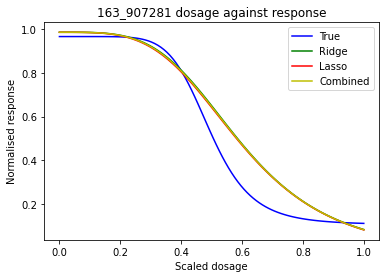

[-3.02287583  1.02306243  3.82626242 -0.05723839]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


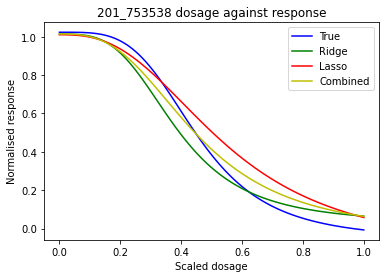

[-6.99192806  0.96601063  8.64385529  0.02294492]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


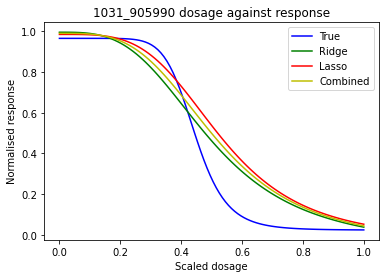

[-3.49359211  0.97852619  4.12186241  0.07888077]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


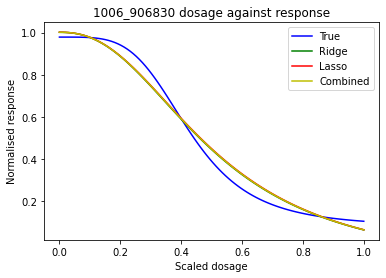

[-5.72555531  0.9846722   9.19515313  0.01268663]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


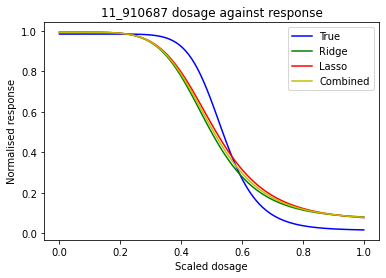

[-1.52016945e+01  1.00898697e+00  4.85331886e+01  6.61701559e-03]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


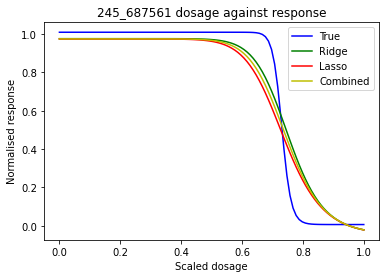

[-2.30242512  0.99837985  3.27645968 -0.09001863]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


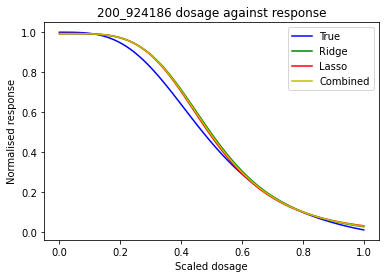

[-8.78135753e+01  1.00386219e+00  1.47752583e+02  8.43069107e-02]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


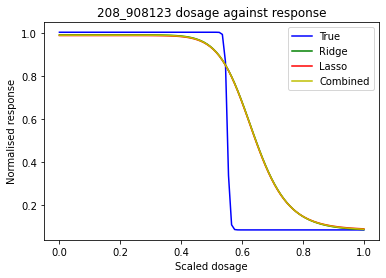

[-3.99503979  1.01256903  4.62688499  0.02476373]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


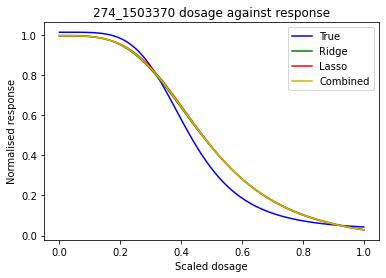

In [13]:
max_int = len(combinedOptimal.index)
rand_int = np.random.randint(0, max_int, 9)
for index in rand_int:
    showTestPredResponses(combinedOptimal.loc[index]['DRUG_COSMICID'])

In [14]:
lassoOptimal.to_csv(_FOLDER2 +'lassoPredicted.csv', index=False)
ridgeOptimal.to_csv(_FOLDER2 +'ridgePredicted.csv', index=False)
combinedOptimal.to_csv(_FOLDER2 +'stackingPredicted.csv', index=False)
trueResults.to_csv(_FOLDER2 +'trueResults.csv', index=False)